In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
from matplotlib.lines import Line2D
import duckdb
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

In [3]:
with open("credentials.json") as f:
    d = json.load(f)

pg = d["postgres"]
aws = d["aws"]
bucket = "s3://carlos-s3-bdet-ducklake" 

def secreto(con):
    print("Iniciando")
    #con = duckdb.connect( )
    con.sql("INSTALL ducklake; LOAD ducklake;")
    con.sql("INSTALL spatial; LOAD spatial;")
    con.sql("INSTALL httpfs; LOAD httpfs;")
    con.sql("INSTALL postgres; LOAD postgres;")

    print("Librerias cargadas")

    con.sql(f"""
        CREATE OR REPLACE SECRET secreto_s3 (
        TYPE s3,
        KEY_ID '{aws["login"]}',
        SECRET '{aws["password"]}',
        REGION 'eu-central-1'
    )
    """)

    print("Secreto s3 creado")

    con.sql(f"""
        CREATE OR REPLACE SECRET secreto_postgres (
        TYPE postgres,
        HOST '{pg["host"]}',
        PORT {pg["port"]},
        DATABASE '{pg["schema"]}',
        USER '{pg["login"]}',
        PASSWORD '{pg["password"]}'
        )
    """)

    print("Secreto postgres creado")

    con.sql("""
        CREATE OR REPLACE SECRET secreto_ducklake (
            TYPE ducklake,
            METADATA_PATH '',
            METADATA_PARAMETERS MAP {'TYPE': 'postgres', 'SECRET': 'secreto_postgres'}
        );
        """)
    
    print("secreto ducklake creado")

    con.sql(f"""
        ATTACH 'ducklake:secreto_ducklake' AS mobility_ducklake (DATA_PATH '{bucket}', OVERRIDE_DATA_PATH TRUE) """)
    con.sql("""
        USE mobility_ducklake """)
    
    print("fin")

In [ ]:
con = duckdb.connect()
secreto(con)

query = """--sql
    SELECT 
        g.origin_id,

        AVG(g.gap_ratio) as avg_gap_ratio,
        
        ST_AsText(s.geometria) as geom_wkt
    FROM gold_infrastructure_gaps g
    JOIN silver_geometries s 
        ON g.origin_id = s.distrito_id
    GROUP BY g.origin_id, s.geometria
"""

df = con.sql(query)

Iniciando
Librerias cargadas
Secreto s3 creado
Secreto postgres creado
secreto ducklake creado
fin


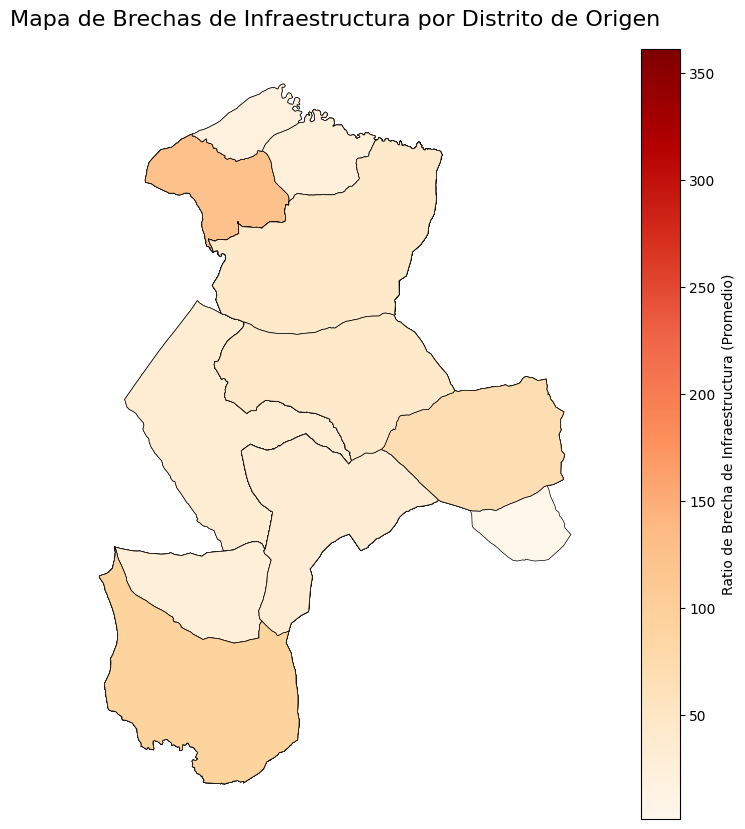

In [10]:
# 3. Ejecutar y obtener DataFrame
df = con.sql(query).df()

# 4. Convertir a GeoDataFrame
# Transformamos la columna de texto WKT a objetos geométricos reales
df['geometry'] = df['geom_wkt'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 5. Definir el sistema de coordenadas (CRS)
# Como tus datos son del MITMA/España, seguramente son ETRS89 UTM 30N (EPSG:25830)
gdf.set_crs("EPSG:25830", inplace=True)

# --- VISUALIZACIÓN ---

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 10))

# Pintar el mapa
gdf.plot(
    column='avg_gap_ratio', # La columna que define el color
    cmap='OrRd',            # Mapa de color (Rojos para indicar "alerta/gap")
    legend=True,            # Mostrar barra de leyenda
    legend_kwds={'label': "Ratio de Brecha de Infraestructura (Promedio)"},
    edgecolor='black',      # Bordes de los distritos
    linewidth=0.5,
    ax=ax
)

# Añadir título y limpiar ejes
plt.title('Mapa de Brechas de Infraestructura por Distrito de Origen', fontsize=16)
plt.axis('off') # Quitar ejes X/Y para que quede limpio

# Mostrar
plt.show()

In [ ]:
con = duckdb.connect()
secreto(con)
df = con.sql("SELECT p.date, pattern_type as cluster, is_holiday FROM gold_date_patterns p LEFT JOIN silver_festivos f ON p.date=f.date").df()

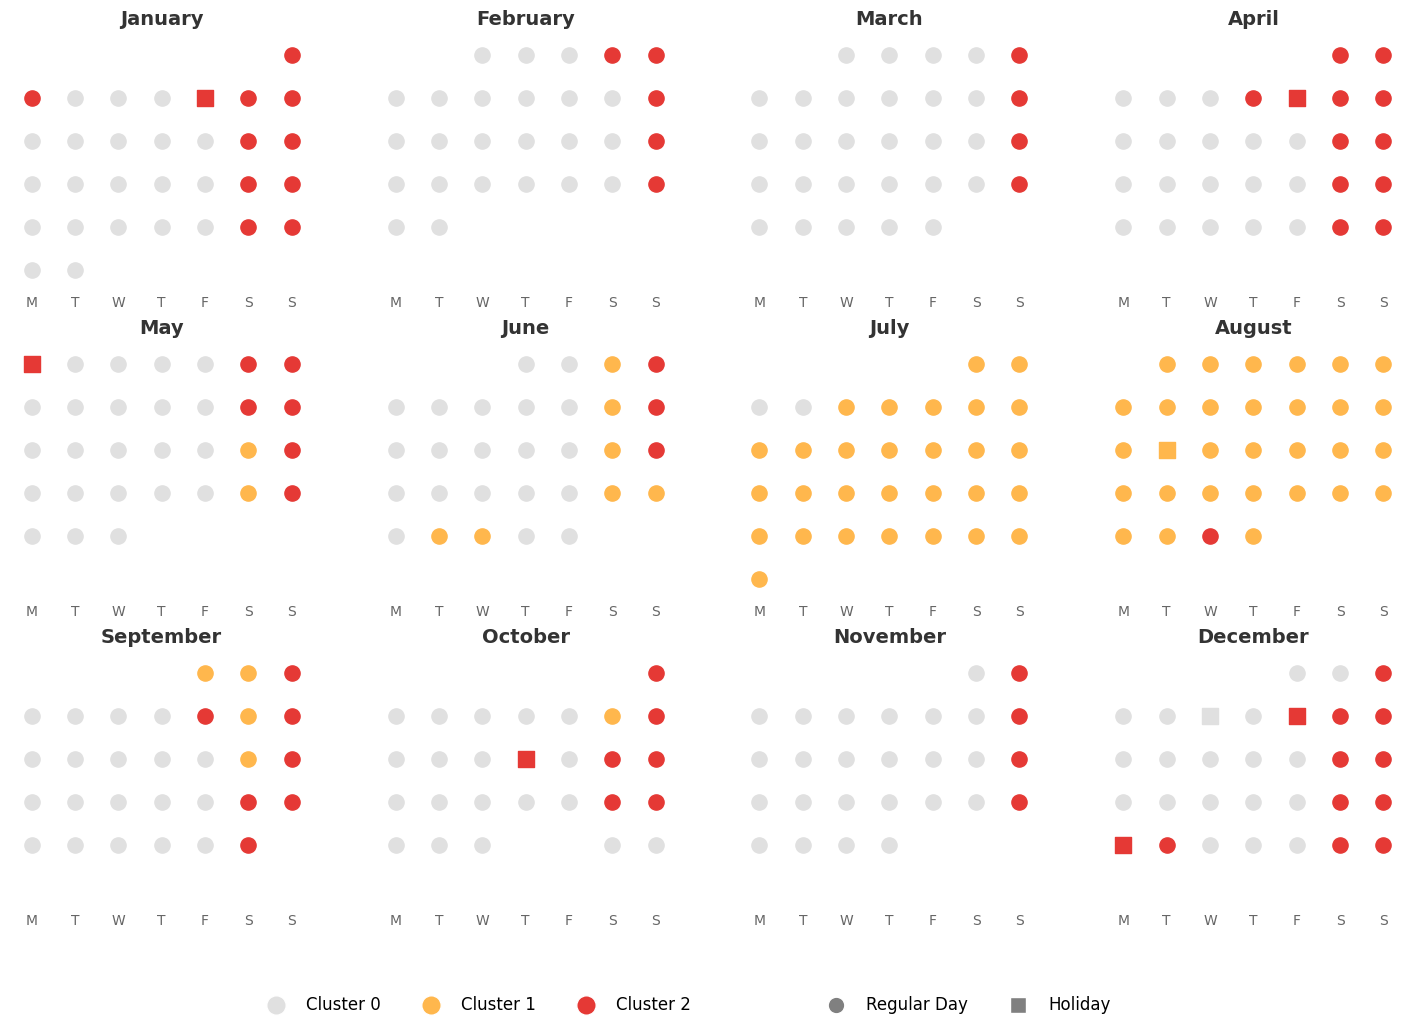

In [18]:


# --- 1. CARGA DE DATOS ---
# Asumimos que 'df' viene de tu consulta DuckDB
# df = con.sql("SELECT date, pattern_type as cluster, is_holiday FROM ...").df()
# Asegúrate de que 'date' es datetime
df['date'] = pd.to_datetime(df['date'])

# --- 2. CONFIGURACIÓN ---
# Colores por Cluster (Ajusta según cuántos K te salgan)
CLUSTER_COLORS = {
    0: '#E0E0E0',  # Gris (Cluster 0)
    1: '#FFB74D',  # Naranja (Cluster 1)
    2: '#E53935',  # Rojo (Cluster 2)
    3: '#1E88E5'   # Azul (Si hubiera Cluster 3)
}

fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()
year = 2023

# --- 3. GENERACIÓN DEL GRÁFICO ---
for i, month in enumerate(range(1, 13)):
    ax = axes[i]
    month_matrix = calendar.monthcalendar(year, month)
    
    for y, week in enumerate(month_matrix):
        for x, day in enumerate(week):
            if day == 0: continue 
            
            # Buscar datos del día
            current_date = pd.Timestamp(year=year, month=month, day=day)
            row = df[df['date'] == current_date]
            
            if not row.empty:
                cluster_id = row.iloc[0]['cluster']
                is_holiday = row.iloc[0]['is_holiday'] # Asegúrate que esta columna sea booleana
                
                # FORMA: Cuadrado si es festivo, Círculo si no
                marker_shape = 's' if is_holiday else 'o'
                
                # COLOR: Según el cluster
                color = CLUSTER_COLORS.get(cluster_id, 'black')
                
                # PINTAR: Tamaño s=120 para que no se toquen
                ax.scatter(x, -y, c=color, marker=marker_shape, s=120)

    # Estética limpia
    ax.set_title(calendar.month_name[month], fontsize=14, fontweight='bold', color='#333333')
    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(-5.5, 0.5)
    ax.set_xticks(range(7))
    ax.set_xticklabels(['M', 'T', 'W', 'T', 'F', 'S', 'S'], color='#666666')
    ax.set_yticks([])
    for spine in ax.spines.values(): spine.set_visible(False)
    ax.tick_params(length=0)

# --- 4. LEYENDA (Tags Numéricos + Formas) ---
legend_elements = []

# Clusters
sorted_clusters = sorted(df['cluster'].unique())
for c_id in sorted_clusters:
    legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                                  label=f'Cluster {c_id}', 
                                  markerfacecolor=CLUSTER_COLORS.get(c_id, 'grey'), 
                                  markersize=14))

# Espaciador
legend_elements.append(Line2D([0], [0], marker='', color='w', label='   ', markersize=0))

# Formas
legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Regular Day', markerfacecolor='grey', markersize=12))
legend_elements.append(Line2D([0], [0], marker='s', color='w', label='Holiday', markerfacecolor='grey', markersize=12))

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.05), 
           ncol=len(legend_elements), frameon=False, fontsize=12)

plt.subplots_adjust(bottom=0.15)
plt.savefig('cluster_analysis_2023.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
con = duckdb.connect()
secreto(con)
df = con.sql("SELECT p.date, pattern_type as cluster, is_holiday FROM gold_date_patterns p LEFT JOIN silver_festivos f ON p.date=f.date").df()


Iniciando
Librerias cargadas
Secreto s3 creado
Secreto postgres creado
secreto ducklake creado
fin


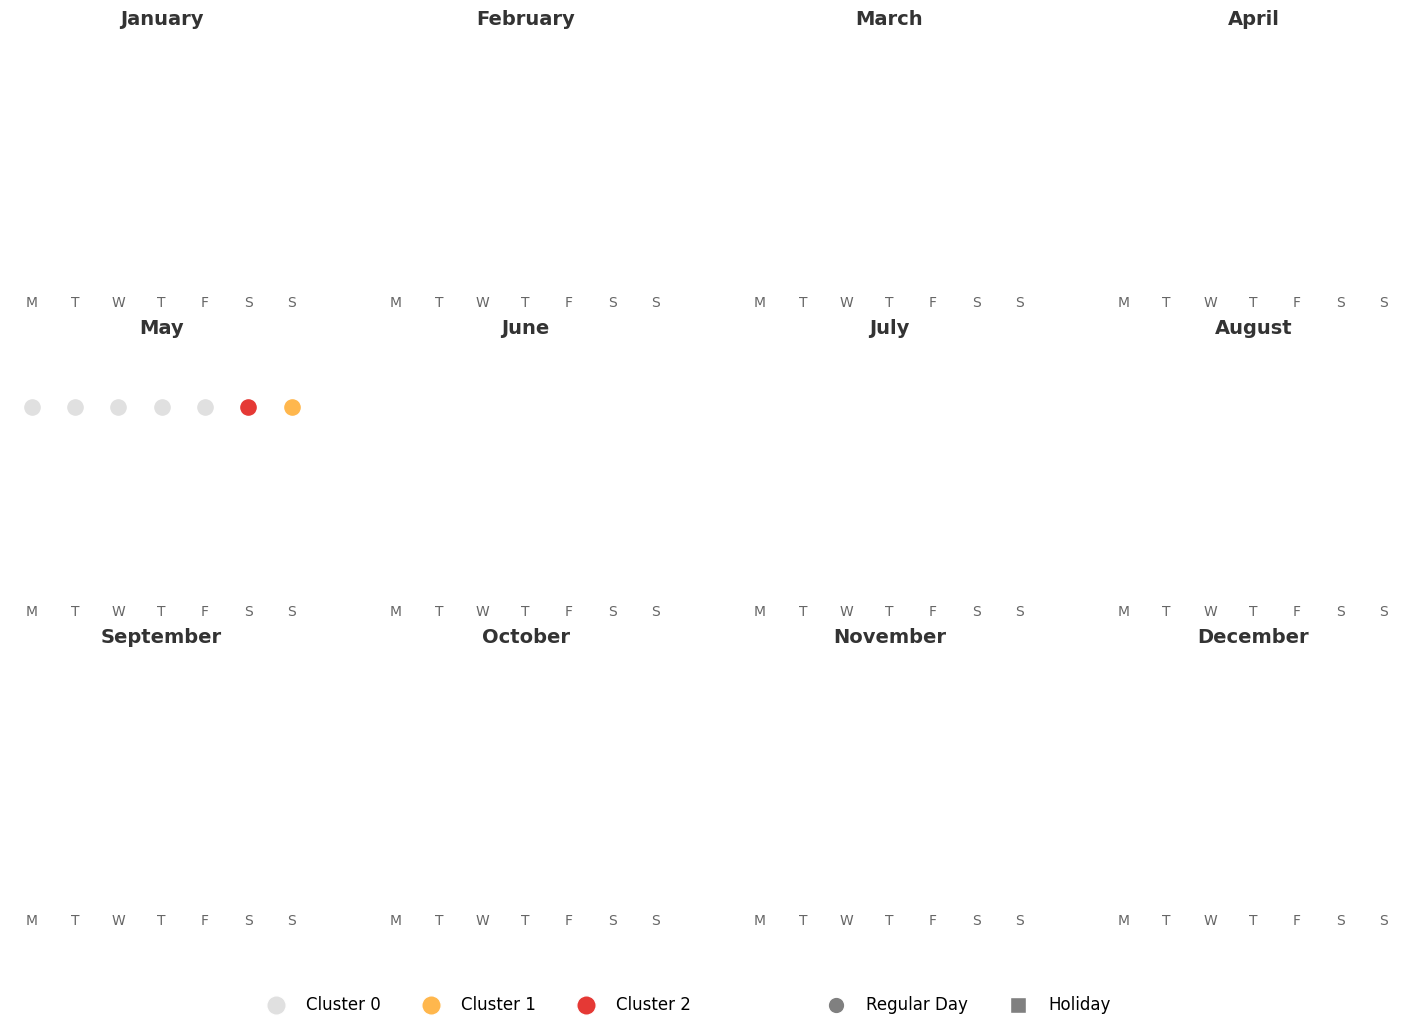

In [5]:

# --- 1. CARGA DE DATOS ---
# Asumimos que 'df' viene de tu consulta DuckDB
# df = con.sql("SELECT date, pattern_type as cluster, is_holiday FROM ...").df()
# Asegúrate de que 'date' es datetime
df['date'] = pd.to_datetime(df['date'])

# --- 2. CONFIGURACIÓN ---
# Colores por Cluster (Ajusta según cuántos K te salgan)
CLUSTER_COLORS = {
    0: '#E0E0E0',  # Gris (Cluster 0)
    1: '#FFB74D',  # Naranja (Cluster 1)
    2: '#E53935',  # Rojo (Cluster 2)
    3: '#1E88E5'   # Azul (Si hubiera Cluster 3)
}

fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()
year = 2023

# --- 3. GENERACIÓN DEL GRÁFICO ---
for i, month in enumerate(range(1, 13)):
    ax = axes[i]
    month_matrix = calendar.monthcalendar(year, month)
    
    for y, week in enumerate(month_matrix):
        for x, day in enumerate(week):
            if day == 0: continue 
            
            # Buscar datos del día
            current_date = pd.Timestamp(year=year, month=month, day=day)
            row = df[df['date'] == current_date]
            
            if not row.empty:
                cluster_id = row.iloc[0]['cluster']
                is_holiday = row.iloc[0]['is_holiday'] # Asegúrate que esta columna sea booleana
                
                # FORMA: Cuadrado si es festivo, Círculo si no
                marker_shape = 's' if is_holiday else 'o'
                
                # COLOR: Según el cluster
                color = CLUSTER_COLORS.get(cluster_id, 'black')
                
                # PINTAR: Tamaño s=120 para que no se toquen
                ax.scatter(x, -y, c=color, marker=marker_shape, s=120)

    # Estética limpia
    ax.set_title(calendar.month_name[month], fontsize=14, fontweight='bold', color='#333333')
    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(-5.5, 0.5)
    ax.set_xticks(range(7))
    ax.set_xticklabels(['M', 'T', 'W', 'T', 'F', 'S', 'S'], color='#666666')
    ax.set_yticks([])
    for spine in ax.spines.values(): spine.set_visible(False)
    ax.tick_params(length=0)

# --- 4. LEYENDA (Tags Numéricos + Formas) ---
legend_elements = []

# Clusters
sorted_clusters = sorted(df['cluster'].unique())
for c_id in sorted_clusters:
    legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                                  label=f'Cluster {c_id}', 
                                  markerfacecolor=CLUSTER_COLORS.get(c_id, 'grey'), 
                                  markersize=14))

# Espaciador
legend_elements.append(Line2D([0], [0], marker='', color='w', label='   ', markersize=0))

# Formas
legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Regular Day', markerfacecolor='grey', markersize=12))
legend_elements.append(Line2D([0], [0], marker='s', color='w', label='Holiday', markerfacecolor='grey', markersize=12))

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.05), 
           ncol=len(legend_elements), frameon=False, fontsize=12)

plt.subplots_adjust(bottom=0.15)
plt.savefig('cluster_analysis_2023.png', dpi=300, bbox_inches='tight')
plt.show()